## Import Packages

In [1]:
from spo.data import knapsack, dataset
from spo.model import knapsackModel
from spo.func import SPOPlus
from spo.eval import unambSPO

In [2]:
import time
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader

In [3]:
torch.manual_seed(135)

## Init Data 

In [4]:
# generate data for grid network (features and costs)
m = 48 # number of items
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
weights, x, c = knapsack.genData(n+1000, p, m, deg=deg, cor=False)

## Build Model 

In [5]:
# model for knapscak
cap = 30
ks_model = knapsackModel(weights, cap)


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-06-13
Using license file C:\Users\Apocrypse\gurobi.lic


In [6]:
# relax
ks_model_rel = ks_model.relax()

## Training

In [7]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [8]:
def train(dataloader, opt_model, num_epochs, learning_rate, l1_lambda=1e-3):
    """
    train model with SPO+ Loss
    args:
      dataloader: dataloader from optDataSet
      model: optModel
      num_epochs: number of epochs
      l2_lambda: l2 regularization parameter
    """
    print('Training...')
    # init model
    lr = LinearRegression()
    # cuda
    if torch.cuda.is_available():
        lr = lr.cuda()
    # training mode
    lr.train()
    # set optimizer
    optimizer = torch.optim.Adam(lr.parameters(), lr=learning_rate)
    # set SPO+ Loss as criterion
    criterion = SPOPlus()
    # train
    time.sleep(1)
    for epoch in tqdm(range(num_epochs)):
        # load data
        for i, data in enumerate(dataloader):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = lr(x)
            loss = criterion.apply(opt_model, cp, c, w, z).mean()
            # l1 reg
            l1_reg = torch.abs(cp - c).sum(dim=1).mean()
            loss += l1_lambda * l1_reg
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return lr

## Experiments

### Training Set Size = 100, Noise Half−width = 0

In [9]:
# set up
n = 100 # number of data
p = 5 # size of feature
e = 0 # noise half−width
cap = 30 # capacity
degs = [1, 2, 4, 6] # list of param deg

In [10]:
# init DataFrame
df1 = pd.DataFrame(columns = degs)

In [11]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        weights, x, c = knapsack.genData(n+1000, p, m, deg=deg, noise_width=e, seed=i)
        c = - c
        # build model
        ks_model = knapsackModel(weights, cap)
        # relax
        ks_model_rel = ks_model.relax()
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        ks_dataset_train_rel = dataset.optDataset(ks_model_rel, x_train, c_train)
        ks_dataset_test = dataset.optDataset(ks_model, x_test, c_test)
        # get data loader
        batch_size = 32
        ks_loader_train_rel = DataLoader(ks_dataset_train_rel, batch_size=batch_size, shuffle=True)
        ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 5e-3 * deg 
        num_epochs = 1000
        lr = train(ks_loader_train_rel, ks_model_rel, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, ks_model, ks_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df1 = df1.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 355.71it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.54it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:48<00:00,  3.46it/s]


Normalized SPO Loss: 0.28%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 351.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 351.65it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:22<00:00,  3.81it/s]


Normalized SPO Loss: 0.38%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 431.98it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 343.32it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:19<00:00,  3.85it/s]


Normalized SPO Loss: 0.63%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 347.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 334.01it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:25<00:00,  3.77it/s]


Normalized SPO Loss: 2.13%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 374.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.16it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:15<00:00,  3.91it/s]


Normalized SPO Loss: 2.09%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 371.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.92it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:17<00:00,  3.88it/s]


Normalized SPO Loss: 0.57%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 368.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 351.24it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:19<00:00,  3.86it/s]


Normalized SPO Loss: 0.75%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 363.71it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 354.69it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:18<00:00,  3.86it/s]


Normalized SPO Loss: 1.33%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 369.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 341.07it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:18<00:00,  3.86it/s]


Normalized SPO Loss: 0.81%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 338.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 267.95it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:32<00:00,  3.68it/s]


Normalized SPO Loss: 0.37%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 418.46it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.87it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:28<00:00,  3.73it/s]


Normalized SPO Loss: 0.66%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 402.63it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 337.30it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:27<00:00,  3.75it/s]


Normalized SPO Loss: 1.67%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 384.11it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.91it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:25<00:00,  3.76it/s]


Normalized SPO Loss: 4.14%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 385.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 351.08it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:23<00:00,  3.79it/s]


Normalized SPO Loss: 1.07%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 356.81it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 362.83it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:22<00:00,  3.82it/s]


Normalized SPO Loss: 0.64%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 361.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.38it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:21<00:00,  3.83it/s]


Normalized SPO Loss: 1.11%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 328.79it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 366.55it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:21<00:00,  3.83it/s]


Normalized SPO Loss: 2.36%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 388.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 350.51it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:20<00:00,  3.83it/s]


Normalized SPO Loss: 0.89%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 417.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 350.79it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:34<00:00,  3.64it/s]


Normalized SPO Loss: 1.15%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 396.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.17it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:20<00:00,  3.85it/s]


Normalized SPO Loss: 2.09%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 348.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.17it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:20<00:00,  3.84it/s]


Normalized SPO Loss: 0.56%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 353.79it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.10it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:21<00:00,  3.82it/s]


Normalized SPO Loss: 0.31%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 320.27it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.44it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:21<00:00,  3.83it/s]


Normalized SPO Loss: 0.67%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 378.44it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.97it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:23<00:00,  3.80it/s]


Normalized SPO Loss: 1.99%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 341.05it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 343.39it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:22<00:00,  3.81it/s]


Normalized SPO Loss: 1.05%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 340.42it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.81it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:14<00:00,  3.92it/s]


Normalized SPO Loss: 0.58%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 379.86it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 358.35it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:14<00:00,  3.92it/s]


Normalized SPO Loss: 0.67%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 343.35it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.72it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:13<00:00,  3.94it/s]


Normalized SPO Loss: 1.88%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 351.91it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 376.67it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:13<00:00,  3.94it/s]


Normalized SPO Loss: 4.22%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 354.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 371.91it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:13<00:00,  3.94it/s]


Normalized SPO Loss: 2.17%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 359.42it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.15it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:15<00:00,  3.91it/s]


Normalized SPO Loss: 1.50%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 337.57it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 375.39it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:15<00:00,  3.92it/s]


Normalized SPO Loss: 1.79%



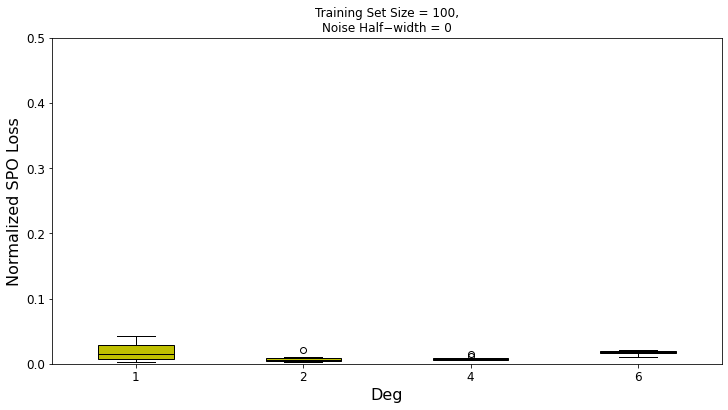

In [12]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df1, boxprops=dict(facecolor='y', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0')
plt.show()

### Training Set Size = 100, Noise Half−width = 0.5

In [13]:
# set
n = 100 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [14]:
# init DataFrame
df2 = pd.DataFrame(columns = degs)

In [15]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        weights, x, c = knapsack.genData(n+1000, p, m, deg=deg, noise_width=e, seed=i)
        c = - c
        # build model
        ks_model = knapsackModel(weights, cap)
        # relax
        ks_model_rel = ks_model.relax()
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        ks_dataset_train_rel = dataset.optDataset(ks_model_rel, x_train, c_train)
        ks_dataset_test = dataset.optDataset(ks_model, x_test, c_test)
        # get data loader
        batch_size = 32
        ks_loader_train_rel = DataLoader(ks_dataset_train_rel, batch_size=batch_size, shuffle=True)
        ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 5e-3 * deg 
        num_epochs = 1000
        lr = train(ks_loader_train_rel, ks_model_rel, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, ks_model, ks_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df2 = df2.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 397.94it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 348.76it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:13<00:00,  3.95it/s]


Normalized SPO Loss: 10.69%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 375.50it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 383.22it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:11<00:00,  3.97it/s]


Normalized SPO Loss: 9.66%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 371.37it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 373.15it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:11<00:00,  3.97it/s]


Normalized SPO Loss: 8.66%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 397.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 381.82it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:28<00:00,  3.72it/s]


Normalized SPO Loss: 9.59%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 360.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 381.83it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:12<00:00,  3.96it/s]


Normalized SPO Loss: 14.43%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 368.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 373.27it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:11<00:00,  3.98it/s]


Normalized SPO Loss: 10.77%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 409.26it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 378.94it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:12<00:00,  3.95it/s]


Normalized SPO Loss: 8.91%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 384.17it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.55it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:11<00:00,  3.97it/s]


Normalized SPO Loss: 7.63%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 336.44it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 376.78it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:12<00:00,  3.97it/s]


Normalized SPO Loss: 12.41%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 397.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.37it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:12<00:00,  3.97it/s]


Normalized SPO Loss: 11.29%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 397.94it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.73it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:17<00:00,  3.88it/s]


Normalized SPO Loss: 10.36%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 350.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.82it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:12<00:00,  3.96it/s]


Normalized SPO Loss: 9.90%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 455.77it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.55it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:12<00:00,  3.96it/s]


Normalized SPO Loss: 14.82%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 331.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 373.30it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:10<00:00,  3.99it/s]


Normalized SPO Loss: 11.17%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 396.35it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 373.99it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:10<00:00,  3.99it/s]


Normalized SPO Loss: 9.00%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 349.33it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 373.44it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:12<00:00,  3.96it/s]


Normalized SPO Loss: 8.09%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 407.55it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 382.12it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:12<00:00,  3.97it/s]


Normalized SPO Loss: 12.83%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 435.94it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 374.89it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:11<00:00,  3.98it/s]


Normalized SPO Loss: 11.54%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 379.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 386.39it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:12<00:00,  3.96it/s]


Normalized SPO Loss: 9.82%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 393.17it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 353.80it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:13<00:00,  3.94it/s]


Normalized SPO Loss: 10.70%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 393.24it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 385.87it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:09<00:00,  4.01it/s]


Normalized SPO Loss: 12.33%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 412.59it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.58it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:10<00:00,  4.00it/s]


Normalized SPO Loss: 10.06%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 372.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.28it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:16<00:00,  3.90it/s]


Normalized SPO Loss: 9.38%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 405.97it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 375.53it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:11<00:00,  3.97it/s]


Normalized SPO Loss: 9.61%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 362.00it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 372.33it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:11<00:00,  3.98it/s]


Normalized SPO Loss: 16.22%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 404.26it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 368.22it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:11<00:00,  3.98it/s]


Normalized SPO Loss: 13.33%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 381.28it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 373.52it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:11<00:00,  3.97it/s]


Normalized SPO Loss: 10.64%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 375.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 348.88it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:12<00:00,  3.96it/s]


Normalized SPO Loss: 10.69%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 428.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.95it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:10<00:00,  3.99it/s]


Normalized SPO Loss: 14.56%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 361.94it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 392.89it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:10<00:00,  3.99it/s]


Normalized SPO Loss: 10.95%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 350.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 383.29it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:20<00:00,  3.83it/s]


Normalized SPO Loss: 8.92%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 417.73it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 365.94it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:13<00:00,  3.94it/s]


Normalized SPO Loss: 9.14%



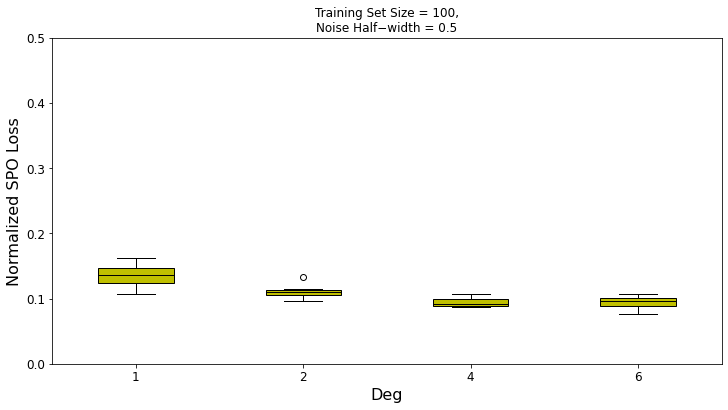

In [16]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df2, boxprops=dict(facecolor='y', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0.5')
plt.show()

## Training Set Size = 1000, Noise Half−width = 0 

In [17]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [18]:
# init DataFrame
df3 = pd.DataFrame(columns = degs)

In [19]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        weights, x, c = knapsack.genData(n+1000, p, m, deg=deg, noise_width=e, seed=i)
        c = - c
        # build model
        ks_model = knapsackModel(weights, cap)
        # relax
        ks_model_rel = ks_model.relax()
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        ks_dataset_train_rel = dataset.optDataset(ks_model_rel, x_train, c_train)
        ks_dataset_test = dataset.optDataset(ks_model, x_test, c_test)
        # get data loader
        batch_size = 32
        ks_loader_train_rel = DataLoader(ks_dataset_train_rel, batch_size=batch_size, shuffle=True)
        ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 5e-3 * deg 
        num_epochs = 200
        lr = train(ks_loader_train_rel, ks_model_rel, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, ks_model, ks_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df3 = df3.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 434.05it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 384.53it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:13<00:00,  2.47s/it]


Normalized SPO Loss: 0.07%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 423.25it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.21it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:10<00:00,  2.45s/it]


Normalized SPO Loss: 0.12%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 423.79it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.66it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:18<00:00,  2.49s/it]


Normalized SPO Loss: 0.22%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 415.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.55it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:19<00:00,  2.50s/it]


Normalized SPO Loss: 0.53%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 436.89it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 376.41it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:11<00:00,  2.46s/it]


Normalized SPO Loss: 0.13%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 400.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 351.32it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:17<00:00,  2.49s/it]


Normalized SPO Loss: 0.13%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 438.43it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 379.37it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:31<00:00,  2.56s/it]


Normalized SPO Loss: 0.27%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 396.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 358.96it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:30<00:00,  2.55s/it]


Normalized SPO Loss: 0.55%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 413.01it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 334.74it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:20<00:00,  2.50s/it]


Normalized SPO Loss: 0.17%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 403.71it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 364.63it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:34<00:00,  2.57s/it]


Normalized SPO Loss: 0.18%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 410.79it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 346.47it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:19<00:00,  2.50s/it]


Normalized SPO Loss: 0.30%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 379.50it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 358.90it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:16<00:00,  2.48s/it]


Normalized SPO Loss: 0.58%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 406.50it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 359.85it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:15<00:00,  2.48s/it]


Normalized SPO Loss: 0.07%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 419.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 360.84it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:15<00:00,  2.48s/it]


Normalized SPO Loss: 0.12%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 417.88it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.84it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:26<00:00,  2.53s/it]


Normalized SPO Loss: 0.22%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 410.98it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.98it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:14<00:00,  2.47s/it]


Normalized SPO Loss: 0.46%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 412.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.11it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:17<00:00,  2.49s/it]


Normalized SPO Loss: 0.06%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 436.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.37it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:15<00:00,  2.48s/it]


Normalized SPO Loss: 0.18%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 414.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 345.21it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:23<00:00,  2.52s/it]


Normalized SPO Loss: 0.22%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 415.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 365.69it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:27<00:00,  2.54s/it]


Normalized SPO Loss: 0.44%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 245.94it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.52it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:29<00:00,  2.55s/it]


Normalized SPO Loss: 0.09%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 406.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.28it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:19<00:00,  2.50s/it]


Normalized SPO Loss: 0.16%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 406.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.79it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:21<00:00,  2.51s/it]


Normalized SPO Loss: 0.25%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 414.86it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.77it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:19<00:00,  2.50s/it]


Normalized SPO Loss: 0.46%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 418.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 348.53it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:18<00:00,  2.49s/it]


Normalized SPO Loss: 0.66%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 410.35it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 356.58it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:19<00:00,  2.50s/it]


Normalized SPO Loss: 0.18%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 419.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.07it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:22<00:00,  2.51s/it]


Normalized SPO Loss: 0.38%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 423.63it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.97it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:06<00:00,  2.43s/it]


Normalized SPO Loss: 0.62%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 434.62it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 395.37it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:07<00:00,  2.44s/it]


Normalized SPO Loss: 0.06%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 379.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.94it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [09:38<00:00,  2.89s/it]


Normalized SPO Loss: 0.13%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 334.46it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 272.42it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [09:52<00:00,  2.96s/it]


Normalized SPO Loss: 0.28%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 360.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.27it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [09:28<00:00,  2.84s/it]


Normalized SPO Loss: 0.63%



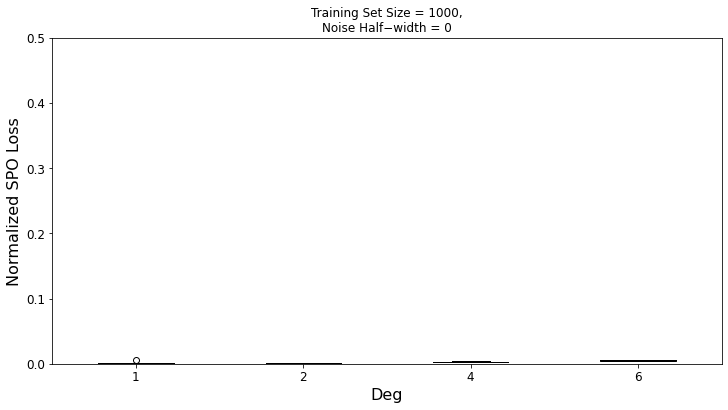

In [20]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df3, boxprops=dict(facecolor='y', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0')
plt.show()

## Training Set Size = 1000, Noise Half−width = 0.5 

In [21]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [22]:
# init DataFrame
df4 = pd.DataFrame(columns = degs)

In [23]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        weights, x, c = knapsack.genData(n+1000, p, m, deg=deg, noise_width=e, seed=i)
        c = - c
        # build model
        ks_model = knapsackModel(weights, cap)
        # relax
        ks_model_rel = ks_model.relax()
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        ks_dataset_train_rel = dataset.optDataset(ks_model_rel, x_train, c_train)
        ks_dataset_test = dataset.optDataset(ks_model, x_test, c_test)
        # get data loader
        batch_size = 32
        ks_loader_train_rel = DataLoader(ks_dataset_train_rel, batch_size=batch_size, shuffle=True)
        ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 5e-3 * deg 
        num_epochs = 200
        lr = train(ks_loader_train_rel, ks_model_rel, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, ks_model, ks_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df4 = df4.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 392.90it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.18it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:59<00:00,  2.70s/it]


Normalized SPO Loss: 9.99%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 410.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.32it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:35<00:00,  2.58s/it]


Normalized SPO Loss: 8.82%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 422.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 368.08it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:25<00:00,  2.53s/it]


Normalized SPO Loss: 7.36%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 406.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.18it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:31<00:00,  2.56s/it]


Normalized SPO Loss: 7.21%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 426.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 372.31it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:28<00:00,  2.54s/it]


Normalized SPO Loss: 12.51%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 421.82it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.08it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:24<00:00,  2.52s/it]


Normalized SPO Loss: 9.46%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 417.56it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.65it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:23<00:00,  2.52s/it]


Normalized SPO Loss: 7.46%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 431.22it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 360.97it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:13<00:00,  2.47s/it]


Normalized SPO Loss: 6.53%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 423.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 378.79it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:19<00:00,  2.50s/it]


Normalized SPO Loss: 11.18%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.71it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 327.77it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:27<00:00,  2.54s/it]


Normalized SPO Loss: 9.95%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 424.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 352.56it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:18<00:00,  2.49s/it]


Normalized SPO Loss: 8.58%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 411.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 356.01it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:24<00:00,  2.52s/it]


Normalized SPO Loss: 7.52%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 409.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 372.48it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:18<00:00,  2.49s/it]


Normalized SPO Loss: 10.92%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 414.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 370.15it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:17<00:00,  2.49s/it]


Normalized SPO Loss: 9.65%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 415.98it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 358.26it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:21<00:00,  2.51s/it]


Normalized SPO Loss: 7.87%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 415.71it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 362.16it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:23<00:00,  2.52s/it]


Normalized SPO Loss: 6.79%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 442.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 381.55it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:05<00:00,  2.43s/it]


Normalized SPO Loss: 10.61%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 442.48it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 375.82it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:05<00:00,  2.43s/it]


Normalized SPO Loss: 9.70%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 438.05it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 386.38it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:09<00:00,  2.45s/it]


Normalized SPO Loss: 7.87%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 440.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.72it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:04<00:00,  2.42s/it]


Normalized SPO Loss: 6.81%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 439.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 383.72it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:06<00:00,  2.43s/it]


Normalized SPO Loss: 10.93%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 429.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 376.24it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:24<00:00,  2.52s/it]


Normalized SPO Loss: 8.68%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 433.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 373.43it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:07<00:00,  2.44s/it]


Normalized SPO Loss: 7.59%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 436.90it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 382.22it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:30<00:00,  2.55s/it]


Normalized SPO Loss: 7.39%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 423.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 371.81it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:44<00:00,  2.62s/it]


Normalized SPO Loss: 14.49%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.02it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [09:44<00:00,  2.92s/it]


Normalized SPO Loss: 10.90%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.37it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [09:51<00:00,  2.96s/it]


Normalized SPO Loss: 8.60%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 371.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [09:46<00:00,  2.93s/it]


Normalized SPO Loss: 7.91%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 350.22it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 320.34it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [09:47<00:00,  2.94s/it]


Normalized SPO Loss: 10.44%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 339.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 322.71it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [09:46<00:00,  2.93s/it]


Normalized SPO Loss: 8.92%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 352.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.18it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [09:46<00:00,  2.93s/it]


Normalized SPO Loss: 7.56%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 243.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 270.63it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [09:43<00:00,  2.92s/it]


Normalized SPO Loss: 7.07%



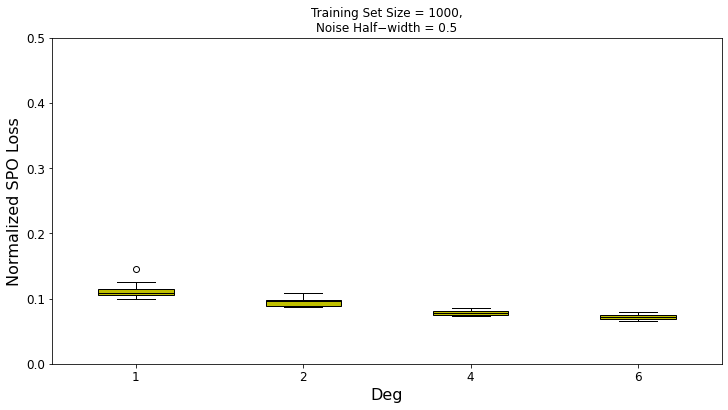

In [24]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df4, boxprops=dict(facecolor='y', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0.5')
plt.show()

## Save File 

In [25]:
df1.to_csv('./res/ks/spoplusrel_n100.csv', index=False)
df2.to_csv('./res/ks/spoplusrel_n100_noise.csv', index=False)
df3.to_csv('./res/ks/spoplusrel_n1000.csv', index=False)
df4.to_csv('./res/ks/spoplusrel_n1000_noise.csv', index=False)